# Visualize RNN Prediction

In [10]:
using Revise
using Flux
using Random
using StaticArrays
using ProgressMeter
using POMDPs
using POMDPModelTools
using POMDPPolicies
using POMDPSimulators
using AutomotiveDrivingModels
using AutoViz
set_color_theme(LIGHTTHEME)
AutoViz._colortheme["background"] = colorant"white"
AutoViz._colortheme["CROSSWALK"] = colorant"gray"
using AutomotivePOMDPs
using AutomotiveSensors
using PedCar
using Reel
using FileIO
using BSON
using BSON: @load
includet("RNNFiltering.jl")
using Main.RNNFiltering

In [2]:
cam = FitToContentCamera(0.)
rng = MersenneTwister(1);

**environment**

In [3]:
mdp = PedCarMDP(pos_res=2.0, vel_res=2., ped_birth=0.7, car_birth=0.7)
pomdp = UrbanPOMDP(env=mdp.env,
                    sensor = GaussianSensor(false_positive_rate=0.0, 
                                            pos_noise = LinearNoise(min_noise=0.5, increase_rate=0.05), 
                                            vel_noise = LinearNoise(min_noise=0.5, increase_rate=0.05)),
                   ego_goal = LaneTag(2, 1),
                     obs_dist = ObstacleDistribution(mdp.env, upper_obs_pres_prob=0., left_obs_pres_prob=1.0, right_obs_pres_prob=1.0),
                   max_cars=1, 
                   max_peds=1, 
                   car_birth=0.05, 
                   ped_birth=0.05, 
                   max_obstacles=1, # no fixed obstacles
                   lidar=false,
                   ego_start=20,
                   ΔT=0.1)
;

In [4]:
# input_length = n_dims(pomdp)
# output_length = n_dims(pomdp)
# model = Chain(LSTM(input_length, 128),
#               Dense(128, output_length))

In [5]:
# function RNNFiltering.process_prediction(pomdp::UrbanPOMDP, b::Vector{Float64}, o::Vector{Float64})
#     n_features = 4
#     n_obstacles = pomdp.max_obstacles
#     b_ = zeros(length(o)) # should be 12 + obstacles
#     b_[1:4] = o[1:4] # ego state fully observable
#     # get car state from b
#     car_presence = b[5]
#     if rand() < car_presence 
#         b_[n_features+1:2*n_features] = b[1:4]
#     else
#         # absent
#         b_[n_features+1:2*n_features] = RNNFiltering.normalized_off_the_grid_pos(pomdp, o[1], o[2])
#     end
    
#     # get ped state from b 
#     ped_presence = b[10]
#     if rand() < ped_presence # softmax 
#         b_[2*n_features+1:3*n_features] = b[6:9]
#     else
#         # absent 
#         b_[2*n_features+1:3*n_features] = RNNFiltering.normalized_off_the_grid_pos(pomdp, o[1], o[2])
#     end
            
#     b_[end - n_features*n_obstacles + 1:end] = o[end - n_features*n_obstacles + 1:end]
#     return b_
# end

## 2-agents tracking

In [6]:
n_models = 5
models = Vector{Chain}(undef, n_models)
for i=1:n_models
    models[i] = BSON.load(joinpath(@__DIR__, "../RNNFiltering/pretrained/model_$(i)0.bson"))[:model] 
end

In [7]:
n_steps = 400
belief_history = Vector{Vector{Float64}}[]
state_history = Scene[]
obs_history = Vector{Float64}[]
presence_history = Tuple{Float64, Float64}[]
s = initialstate(pomdp, rng)
for m in models
    Flux.reset!(m)
end
@time for i=1:n_steps
    global s
    if isterminal(pomdp, s)
        break 
    end
    push!(state_history, s)
    a = UrbanAction(0.)
    o = initialobs(pomdp, s, rng)
    beliefs = Vector{Vector{Float64}}(undef, n_models)
    car_pres, ped_pres = 0., 0.
    for i=1:n_models       
        pred = models[i](o).data
        car_pres += pred[5]
        ped_pres += pred[10]
        b_, _ = RNNFiltering.process_prediction(pomdp, pred, o, 0.5)
        beliefs[i] = b_
    end
    push!(presence_history, (car_pres/n_models, ped_pres/n_models))
    push!(belief_history, beliefs)
    push!(obs_history, o)
    sp = gen(DDNOut(:sp), pomdp, s, a, rng)
    s = sp
end


  6.293361 seconds (13.16 M allocations: 732.672 MiB, 4.13% gc time)


In [8]:
function AutomotivePOMDPs.animate_scenes(scenes::Vector{Scene}, 
                                         observations::Vector{Vector{Float64}}, 
                                         beliefs::Vector{Vector{Vector{Float64}}}, 
                                         presences::Vector{Tuple{Float64, Float64}},
                                         pomdp::UrbanPOMDP;
                                         sim_dt = 0.1,
                                         cam = StaticCamera(VecE2(0., -8.), 16.0))
    env = pomdp.env 
    duration = length(scenes)*sim_dt
    fps = Int(1/sim_dt)
    function render_rec(t, dt)
        frame_index = Int(floor(t/dt)) + 1
        overlays = SceneOverlay[AutoViz.IDOverlay()]
        obs = [veh for veh in obs_to_scene(pomdp, observations[frame_index]) if veh.id != EGO_ID]
        obs_overlay = GaussianSensorOverlay(sensor=pomdp.sensor, o=obs, color=AutoViz.MONOKAY["color2"])
        push!(overlays, obs_overlay)
        occlusion_overlay = OcclusionOverlay(obstacles=mdp.env.obstacles)
        push!(overlays, occlusion_overlay)
        for b in beliefs[frame_index]
            bel = [veh for veh in obs_to_scene(pomdp, b) if veh.id != EGO_ID]
            bel_overlay = GaussianSensorOverlay(sensor=pomdp.sensor, o=bel, color=AutoViz.MONOKAY["color4"])            
            push!(overlays, bel_overlay)
        end
        push!(overlays, HistogramOverlay(pos=VecE2(-15., -20.), val=presences[frame_index][1], label="car"))
        push!(overlays, HistogramOverlay(pos=VecE2(-12., -20.), val=presences[frame_index][2], label="ped"))
        push!(overlays, TextOverlay(text=["Probability of presence"], pos=VecSE2(-17,-14.), font_size=15, incameraframe=true))
        return AutoViz.render(scenes[frame_index], env, overlays, cam=cam)
    end
    return duration, fps, render_rec
end
    
    

In [9]:
duration, fps, render_hist = animate_scenes(state_history, obs_history, belief_history, presence_history, pomdp, sim_dt=pomdp.ΔT)
speed_factor = 2
film = roll(render_hist, fps = speed_factor*fps, duration = duration/speed_factor)

Frames{MIME{Symbol("image/png")}}("C:\\Users\\Maxime\\AppData\\Local\\Temp\\jl_mB5Rce", 0x0000000000000190, 20.0, nothing)

## Single Entity Tracking

In [4]:
function process_single_entity_prediction(pomdp::UrbanPOMDP, b::Vector{<:Real}, o::Vector{<:Real}, pres_threshold::Float64=0.5)
    n_features = pomdp.n_features
    b_ = zeros(3*n_features) # should be 8 + obstacles
    b_[1:4] = o[1:4] # ego state fully observable
    # get car state from b
    car_presence = b[5]
    if rand() <  car_presence && (pres_threshold < car_presence)
        b_[n_features+1:2*n_features] = b[1:4]
    else
        # absent
        b_[n_features+1:2*n_features] = normalized_off_the_grid_pos(pomdp, o[1], o[2])
    end
    b_[2*n_features + 1:end] = o[end - n_features+1:end]
    return b_
end

process_single_entity_prediction (generic function with 2 methods)

In [12]:
car_pomdp = deepcopy(pomdp)
car_pomdp.max_peds = 0
ped_pomdp = deepcopy(pomdp)
ped_pomdp.max_cars = 0
pedcar_pomdp = deepcopy(pomdp)
pedcar_pomdp.max_peds = 1
pedcar_pomdp.max_cars = 1
pedcar_pomdp.max_obstacles = 1

1

In [13]:
n_models = 5
car_models = Vector{Chain}(undef, n_models)
ped_models = Vector{Chain}(undef, n_models)
for i=1:n_models
    car_models[i] = BSON.load(joinpath(@__DIR__, "../RNNFiltering/pretrained/model_car_$i.bson"))[:model] 
#     Flux.loadparams!(car_models[i], BSON.load("weights_car_$i.bson")[:weights])
    ped_models[i] = BSON.load(joinpath(@__DIR__, "../RNNFiltering/pretrained/model_ped_$i.bson"))[:model]
#     Flux.loadparams!(ped_models[i], BSON.load("weights_ped_$i.bson")[:weights])
end
pres_threshold = 0.3

0.3

In [14]:
n_steps = 400
pres_threshold = 0.5
belief_history = Vector{Tuple{Vector{Float64},Vector{Float64}}}[]
state_history = Scene[]
obs_history = Vector{Float64}[]
presence_history = Tuple{Float64, Float64}[]
s = initialstate(pomdp, rng)
for (cm, pm) in zip(car_models, ped_models)
    Flux.reset!(cm)
    Flux.reset!(pm)
end
@time for i=1:n_steps
    global s
    if isterminal(pomdp, s)
        break 
    end
    push!(state_history, s)
    a = UrbanAction(0.)
    o = initialobs(pomdp, s, rng)
    ego, car_map, ped_map, obs_map = split_o(o, pomdp)
    beliefs = Vector{Tuple{Vector{Float64},Vector{Float64}}}(undef, n_models)
    car_pres, ped_pres = 0., 0.
    for i=1:n_models       
        if haskey(car_map, CAR_ID)
            car_o = car_map[CAR_ID]
        else
            car_o = normalized_off_the_grid_pos(pomdp, o[1], o[2])
        end
        if haskey(ped_map, PED_ID)
            ped_o = ped_map[PED_ID]
        else
            ped_o = normalized_off_the_grid_pos(pomdp, o[1], o[2])
        end
        car_pred = car_models[i](vcat(ego, car_o, obs_map[1])).data
        ped_pred = ped_models[i](vcat(ego, ped_o, obs_map[1])).data
        car_pres += car_pred[5]
        ped_pres += ped_pred[5]
        car_ = process_single_entity_prediction(car_pomdp, car_pred, o, pres_threshold)
        ped_ = process_single_entity_prediction(ped_pomdp, ped_pred, o, pres_threshold)
        beliefs[i] = (car_, ped_)
    end
    push!(presence_history, (car_pres/n_models, ped_pres/n_models))
    push!(belief_history, beliefs)
    push!(obs_history, o)
    sp = gen(DDNOut(:sp), pomdp, s, a, rng)
    s = sp
end

  0.470102 seconds (1.05 M allocations: 138.783 MiB, 5.93% gc time)


In [15]:
function AutomotivePOMDPs.animate_scenes(scenes::Vector{Scene}, 
                                         observations::Vector{Vector{Float64}}, 
                                         beliefs::Vector{Vector{Tuple{Vector{Float64},Vector{Float64}}}}, 
                                         presences::Vector{Tuple{Float64, Float64}},
                                         pomdp::UrbanPOMDP;
                                         sim_dt = 0.1,
                                         cam = StaticCamera(VecE2(0., -8.), 16.0))
    env = pomdp.env 
    duration = length(scenes)*sim_dt
    fps = Int(1/sim_dt)
    function render_rec(t, dt)
        frame_index = Int(floor(t/dt)) + 1
        overlays = SceneOverlay[AutoViz.IDOverlay()]
        obs = [veh for veh in obs_to_scene(pomdp, observations[frame_index]) if veh.id != EGO_ID]
        obs_overlay = GaussianSensorOverlay(sensor=pomdp.sensor, o=obs, color=AutoViz.MONOKAY["color2"])
        push!(overlays, obs_overlay)
        occlusion_overlay = OcclusionOverlay(obstacles=mdp.env.obstacles)
        push!(overlays, occlusion_overlay)
        for (cb, pb) in beliefs[frame_index]
            cb_ = [veh for veh in obs_to_scene(car_pomdp, cb) if veh.id != EGO_ID]
            pb_ = [veh for veh in obs_to_scene(ped_pomdp, pb) if veh.id != EGO_ID]
            cbel_overlay = GaussianSensorOverlay(sensor=pomdp.sensor, o=cb_, color=AutoViz.MONOKAY["color4"])            
            push!(overlays, cbel_overlay)
            pbel_overlay = GaussianSensorOverlay(sensor=pomdp.sensor, o=pb_, color=AutoViz.MONOKAY["color4"])            
            push!(overlays, pbel_overlay)
        end
        push!(overlays, HistogramOverlay(pos=VecE2(-15., -20.), val=presences[frame_index][1], label="car"))
        push!(overlays, HistogramOverlay(pos=VecE2(-12., -20.), val=presences[frame_index][2], label="ped"))
        push!(overlays, TextOverlay(text=["Probability of presence"], pos=VecSE2(-17,-14.), font_size=15, incameraframe=true))
        return AutoViz.render(scenes[frame_index], env, overlays, cam=cam)
    end
    return duration, fps, render_rec
end

In [16]:
duration, fps, render_hist = animate_scenes(state_history, obs_history, belief_history, presence_history, pomdp, sim_dt=pomdp.ΔT)
speed_factor = 2
film = roll(render_hist, fps = speed_factor*fps, duration = duration/speed_factor)

Frames{MIME{Symbol("image/png")}}("C:\\Users\\Maxime\\AppData\\Local\\Temp\\jl_MyOJ7h", 0x0000000000000190, 20.0, nothing)

## Belief figure for paper

Scenario with one car and one obstacle

In [132]:
car_pomdp = deepcopy(pomdp)
car_pomdp.max_peds = 0
car_pomdp.car_birth = 0.05
n_models = 5
car_models = Vector{Chain}(undef, n_models)
ped_models = Vector{Chain}(undef, n_models)
for i=1:n_models
    car_models[i] = BSON.load(joinpath(@__DIR__, "../RNNFiltering/pretrained/model_car_$i.bson"))[:model] 
end
pres_threshold = 0.3

0.3

In [145]:
n_steps = 400
pres_threshold = 0.5
belief_history = Vector{Vector{Float64}}[]
state_history = Scene[]
obs_history = Vector{Float64}[]
presence_history = Float64[]

## initial state 
s = initialstate(car_pomdp, rng)
# ego =  get_by_id(s, EGO_ID)
# car_pomdp.env.obstacles = [ ConvexPolygon([VecE2(-23.875, -7.800),VecE2(-5.125, -7.800),VecE2(-5.125, -3.3000),VecE2(-23.875, -3.3000)], 4)]
car_pomdp.env.obstacles = [ConvexPolygon([VecE2(-30.000, -7.500),VecE2(-5.000, -7.500),VecE2(-5.000, -3.000),VecE2(-30.000, -3.000)])]
# posF = Frenet(car_pomdp.env.roadway[LaneTag(3,1)], 0.0)
# car = Vehicle(VehicleState(posF,car_pomdp.env.roadway, 1.0), VehicleDef(), 2)
# s = Scene([ego,car])

# reset models
for cm in car_models
    Flux.reset!(cm)
end

# simulation loop
@time for i=1:n_steps
    global s
    if isterminal(car_pomdp, s)
        break 
    end
    push!(state_history, s)
    a = UrbanAction(0.)
    o = initialobs(car_pomdp, s, rng)
    ego, car_map, ped_map, obs_map = split_o(o, car_pomdp)
    beliefs = Vector{Vector{Float64}}(undef, n_models)
    car_pres = 0.
    for i=1:n_models       
        if haskey(car_map, CAR_ID)
            car_o = car_map[CAR_ID]
        else
            car_o = normalized_off_the_grid_pos(car_pomdp, o[1], o[2])
        end
        car_pred = car_models[i](vcat(ego, car_o, obs_map[1])).data
        car_pres += car_pred[5]
        car_ = process_single_entity_prediction(car_pomdp, car_pred, o, pres_threshold)
        beliefs[i] = car_
    end
    push!(presence_history, car_pres/n_models)
    push!(belief_history, beliefs)
    push!(obs_history, o)
    sp = gen(DDNOut(:sp), car_pomdp, s, a, rng)
    s = sp
end
import Cairo
# AutoViz.render(state_history[1], car_pomdp.env, 
#                [HistogramOverlay(pos=VecE2(-20., -13.), val=0.5, label="", line_color=colorant"black")],
#                cam=StaticCamera(VecE2(-12., -8.5), 25.0),
#                surface=Cairo.CairoPDFSurface(IOBuffer(), 1000, 450))
AutoViz.render([car_pomdp.env, state_history[1]],
               cam=StaticCamera(VecE2(-12., -8.5), 25.0),
               surface=Cairo.CairoPDFSurface(IOBuffer(), 1000, 450))

  0.301380 seconds (584.94 k allocations: 76.407 MiB)


MethodError: MethodError: no method matching render(::Array{Any,1}, ::Array{HistogramOverlay,1}; cam=StaticCamera(VecE2(-12.000, -8.500), 25.0), surface=Cairo.CairoSurfaceIOStream{UInt32}(Ptr{Nothing} @0x00000000ab4a87e0, 1000.0, 450.0, IOBuffer(data=UInt8[...], readable=true, writable=true, seekable=true, append=false, size=0, maxsize=Inf, ptr=1, mark=-1)))
Closest candidates are:
  render(!Matched::Frame{Entity{S,D,I}}, ::R; canvas_width, canvas_height, rendermodel, cam, car_colors, surface) where {S, D, I, R} at C:\Users\Maxime\.julia\packages\AutoViz\p5jgm\src\interface.jl:59
  render(!Matched::Frame{Entity{S,D,I}}, ::R, !Matched::AbstractArray{O,1}; canvas_width, canvas_height, rendermodel, cam, car_colors, surface) where {S, D, I, O<:SceneOverlay, R} at C:\Users\Maxime\.julia\packages\AutoViz\p5jgm\src\overlays.jl:13
  render(::Any; overlays, rendermodel, cam, canvas_height, canvas_width, surface) at C:\Users\Maxime\.julia\packages\AutoViz\p5jgm\src\renderable.jl:33

In [142]:
function AutomotivePOMDPs.animate_scenes(scenes::Vector{Scene}, 
                                         observations::Vector{Vector{Float64}}, 
                                         beliefs::Vector{Vector{Vector{Float64}}}, 
                                         presences::Vector{Float64},
                                         pomdp::UrbanPOMDP;
                                         sim_dt = 0.1,
                                         cam = StaticCamera(VecE2(-12., -8.5), 24.0))
    env = car_pomdp.env 
    duration = length(scenes)*sim_dt
    fps = Int(1/sim_dt)
    function render_rec(t, dt)
        frame_index = Int(floor(t/dt)) + 1
        overlays = SceneOverlay[]
        obs = [veh for veh in obs_to_scene(car_pomdp, observations[frame_index]) if veh.id != EGO_ID]
        obs_overlay = GaussianSensorOverlay(sensor=car_pomdp.sensor, o=obs, color=RGBA(0.0,1,0.0, 0.5))
        push!(overlays, obs_overlay)
        for cb in beliefs[frame_index]
            cb_ = [veh for veh in obs_to_scene(car_pomdp, cb) if veh.id != EGO_ID]
            cbel_overlay = GaussianSensorOverlay(sensor=car_pomdp.sensor, o=cb_, color=RGBA(0,0,1,0.4))            
            push!(overlays, cbel_overlay)
        end
        push!(overlays, HistogramOverlay(pos=VecE2(-20., -13.), val=presences[frame_index], label="", line_color=colorant"black"))
#         push!(overlays, TextOverlay(text=["Probability of presence"], pos=VecSE2(-17,-14.), font_size=15, incameraframe=true))
        return AutoViz.render(scenes[frame_index], env, overlays, cam=cam, 
                            car_colors=Dict(1=>AutoViz._colortheme["COLOR_CAR_EGO"], 2=>AutoViz._colortheme["COLOR_CAR_OTHER"]),
                            surface=Cairo.CairoPDFSurface(IOBuffer(), 1000, 450))
    end
    return duration, fps, render_rec
end

In [143]:
duration, fps, render_hist = animate_scenes(state_history, obs_history, belief_history, presence_history, pomdp, sim_dt=pomdp.ΔT)
speed_factor = 2
film = roll(render_hist, fps = speed_factor*fps, duration = duration/speed_factor)

Frames{MIME{Symbol("image/png")}}("C:\\Users\\Maxime\\AppData\\Local\\Temp\\jl_KSPWTr", 0x0000000000000190, 20.0, nothing)

In [29]:
println(AutoViz.MONOKAY["color4"])

RGB{N0f8}(0.976,0.592,0.122)


## Draft

In [11]:
struct SingleAgentTracker <: Updater
    single_pomdp::UrbanPOMDP
    models::Vector{Chain}
    pres_threshold::Float64
    agent_def::VehicleDef
end

struct SingleAgentBelief 
    predictions::Vector{Vector{Float64}}
    obs::Vector{Float64}
    single_pomdp::UrbanPOMDP
end

function POMDPs.update(up::SingleAgentTracker, bold::SingleAgentBelief, a::UrbanAction, o::Vector{Float64}) # observation should be consistent with up.pomdp
    n_models = length(up.models)
    predictions = Vector{Vector{Float64}}(undef, n_models)
    for (i,m) in enumerate(up.models)
        predictions[i] = process_single_entity_prediction(up.single_pomdp, m(o).data, o, up.pres_threshold)
    end
    return SingleAgentBelief(predictions, o, up.single_pomdp)        
end
    


In [12]:
up = SingleAgentTracker(ped_pomdp, ped_models, pres_threshold, VehicleDef())
policy = FunctionPolicy(s -> UrbanAction(0.))
s0 = initialstate(ped_pomdp, rng)
b0 = SingleAgentBelief(Vector{Vector{Float64}}(undef, n_models), zeros(n_dims(pomdp)), ped_pomdp)
hr = HistoryRecorder(max_steps=100, rng=rng)
@time hist = simulate(hr, ped_pomdp, policy, up, b0, s0);

DimensionMismatch: DimensionMismatch("second dimension of A, 12, does not match length of x, 16")

In [13]:
animate_history(hist, ped_pomdp,
                belief_overlays = b -> [SingleAgentBeliefOverlay(b)],
                extra_overlays = [IDOverlay()])

UndefVarError: UndefVarError: animate_history not defined

In [14]:
struct SingleAgentBeliefOverlay <: SceneOverlay
    b::SingleAgentBelief
    color::Colorant
end

SingleAgentBeliefOverlay(b::SingleAgentBelief;  color = MONOKAI["color4"]) = SingleAgentBeliefOverlay(b, color)

function AutoViz.render!(rendermodel::RenderModel, overlay::SingleAgentBeliefOverlay, scene::Scene, env::OccludedEnv)
    for pred in overlay.b.predictions
        bel = [veh for veh in obs_to_scene(overlay.b.single_pomdp, pred) if veh.id != EGO_ID]
        AutoViz.render!(rendermodel, GaussianSensorOverlay(sensor=overlay.b.single_pomdp.sensor, o=bel, color=overlay.color), scene, env) 
    end
end

In [15]:
function animate_history(hist::POMDPHistory, pomdp::UrbanPOMDP;
                         state_overlays= x->SceneOverlay[],
                         action_overlays = x->SceneOverlay[],
                         obs_overlays = x->SceneOverlay[],
                         belief_overlays = x->SceneOverlay[],
                         ainfo_overlays = x->SceneOverlay[],
                         info_overlays = x->SceneOverlay[],
                         extra_overlays = SceneOverlay[],
                         step_overlays = x->SceneOverlay[],
                         speed_factor::Int64 = 1,
                         cam=FitToContentCamera(0.),
                         sim_dt=0.1)
    env = pomdp.env 
    duration = (length(hist.state_hist)-1)*sim_dt
    fps = Int(1/sim_dt)
    function render(t, dt)
        frame_index = Int(floor(t/dt)) + 1
        s = hist.state_hist[frame_index+1]
        a = hist.action_hist[frame_index]
        o = hist.observation_hist[frame_index]
        b = hist.belief_hist[frame_index + 1]
        ai = hist.ainfo_hist[frame_index]
        info = hist.info_hist[frame_index]
        overlays = SceneOverlay[]
        push!.(Ref(overlays), state_overlays(s))
        push!.(Ref(overlays), action_overlays(a))
        push!.(Ref(overlays), obs_overlays(o))
        push!.(Ref(overlays), belief_overlays(b))
        push!.(Ref(overlays), ainfo_overlays(ai))
        push!.(Ref(overlays), info_overlays(info))
        push!.(Ref(overlays), extra_overlays)
        push!.(Ref(overlays), step_overlays(frame_index))
        AutoViz.render(s, env, overlays, cam=cam)
    end
    film = roll(render, fps = speed_factor*fps, duration = duration/speed_factor)
    return film
end

animate_history (generic function with 1 method)

## Tracking Multiple Targets

In [16]:

struct MultipleAgentsTracker <: Updater
    pomdp::UrbanPOMDP
    ref_trackers::Dict{Int64, SingleAgentTracker} # bank of uninitialized tracker mapping class to reference tracker
    single_trackers::Dict{Int64, SingleAgentTracker}
end

struct MultipleAgentsBelief
    single_beliefs::Dict{Int64, SingleAgentBelief}
    o::Vector{Float64}
    pomdp::UrbanPOMDP
end


In [17]:
function POMDPs.update(up::MultipleAgentsTracker, bold::MultipleAgentsBelief, a::UrbanAction, o::UrbanObs)
#     println("Updater keys: ", keys(up.single_trackers))
#     println("belief keys: ", keys(bold.single_beliefs))
    ego, car_map, ped_map, obs_map = split_o(o, up.pomdp)
    bnew = Dict{Int64, SingleAgentBelief}()
    updated_ids = Set{Int64}()
    for (i, veh_map) in enumerate((car_map, ped_map))
        class = i == 1 ? AgentClass.CAR : AgentClass.PEDESTRIAN
        for (vehid, veh) in veh_map # iterate through visible cars
            single_o = vcat(ego, veh, obs_map[1])
            if haskey(up.single_trackers, vehid)
                @assert haskey(up.single_trackers, vehid)
                bnew[vehid] = update(up.single_trackers[vehid], bold.single_beliefs[vehid], a, single_o)
                push!(updated_ids, vehid)
            else
                # start new tracker 
                up.single_trackers[vehid] = deepcopy(up.ref_trackers[class])
#                 println("Starting new tracker for vehicle: ", vehid)
                init_belief = SingleAgentBelief(Vector{Vector{Float64}}(), Vector{Float64}(), up.single_trackers[vehid].single_pomdp)
                bnew[vehid] = update(up.single_trackers[vehid], init_belief, a, single_o)
                push!(updated_ids, vehid)
            end
        end
    end
      
    
    # add absent ped and car for each obstacle
    for (obsid, obs) in obs_map
        absent_obs = vcat(ego, get_normalized_absent_state(up.pomdp, ego), obs)
        for class in (AgentClass.CAR, AgentClass.PEDESTRIAN)
            if class == AgentClass.CAR
                new_id = pomdp.max_cars + obsid + 1
            else
                new_id = 100 + pomdp.max_peds + obsid + 1
            end
            
            if haskey(up.single_trackers, new_id) && haskey(bold.single_beliefs, new_id)
                bnew[new_id] = update(up.single_trackers[new_id], bold.single_beliefs[new_id], a, absent_obs)
            else
                # start new tracker 
                up.single_trackers[new_id] = deepcopy(up.ref_trackers[class])
                Flux.reset!.(up.single_trackers[new_id].models)
                init_belief = SingleAgentBelief(Vector{Vector{Float64}}(), Vector{Float64}(), up.single_trackers[new_id].single_pomdp)
                bnew[new_id] = update(up.single_trackers[new_id], init_belief, a, absent_obs)
            end
            push!(updated_ids, new_id)
        end
    end
    
    for (oldid, _) in up.single_trackers
        absent_obs = vcat(ego, get_normalized_absent_state(up.pomdp, ego), obs_map[1]) 
        if oldid ∉ updated_ids
#             println("Vehicle $oldid disappeared! still tracking")
            init_belief = SingleAgentBelief(Vector{Vector{Float64}}(), Vector{Float64}(), up.single_trackers[oldid].single_pomdp)
            bnew[oldid] = update(up.single_trackers[oldid], init_belief, a, absent_obs)
        end
    end
    return MultipleAgentsBelief(bnew, o. up.pomdp)
end

In [33]:
global STEP = 0
function POMDPModelTools.generate_sori(pomdp::UrbanPOMDP, s::Scene, a::UrbanAction, rng::AbstractRNG)
#     global STEP
#     STEP += 1
#     println("SIM STEP: ", STEP)
    return generate_sor(pomdp, s, a, rng)..., nothing
end

In [171]:
car_pomdp = deepcopy(pomdp)
car_pomdp.max_peds = 0
car_pomdp.max_cars = 1
ped_pomdp = deepcopy(pomdp)
ped_pomdp.max_peds = 1
ped_pomdp.max_cars = 0
pedcar_pomdp = deepcopy(pomdp)
pedcar_pomdp.max_peds = 1
pedcar_pomdp.max_cars = 1
pedcar_pomdp.max_obstacles = 0

0

In [172]:
global STEP = 0
pomdp.max_cars = 2
pomdp.max_peds = 2
ref_updaters = Dict(AgentClass.PEDESTRIAN => SingleAgentTracker(ped_pomdp, ped_models, pres_threshold, VehicleDef()),
                    AgentClass.CAR =>  SingleAgentTracker(car_pomdp, car_models, pres_threshold, VehicleDef()))
up = MultipleAgentsTracker(pomdp, ref_updaters, Dict{Int64, SingleAgentTracker}())
policy = FunctionPolicy(s -> UrbanAction(0.))
s0 = initialstate(pomdp, rng)
b0 = MultipleAgentsBelief(Dict{Int64, SingleAgentBelief}(), Vector{Float64}())
hr = HistoryRecorder(max_steps=100, rng=rng)
@time hist = simulate(hr, pomdp, policy, up, b0, s0);

  4.612841 seconds (2.25 M allocations: 511.541 MiB, 20.21% gc time)


In [173]:
animate_history(hist, pomdp,
                obs_overlays = o -> [GaussianSensorOverlay(sensor=pomdp.sensor, o=[veh for veh in obs_to_scene(pomdp, o) if veh.id != EGO_ID], color=MONOKAI["color2"])],
                belief_overlays = b -> [MultipleAgentsBeliefOverlay(b)],
                step_overlays = s -> [TextOverlay(text = ["step: $s"], font_size=20, pos=VecE2(pomdp.env.params.x_min + 3.,4.), incameraframe=true)],
                extra_overlays = [IDOverlay()],
                cam =  StaticCamera(VecE2(0., -8.), 14.0))

Frames{MIME{Symbol("image/png")}}("/tmp/tmppFYKow", 0x0000000000000064, 10.0, nothing)

In [118]:
struct MultipleAgentsBeliefOverlay <: SceneOverlay
    b::MultipleAgentsBelief
    color::Colorant
end

MultipleAgentsBeliefOverlay(b::MultipleAgentsBelief;color = MONOKAI["color4"]) = MultipleAgentsBeliefOverlay(b, color)

function AutoViz.render!(rendermodel::RenderModel, overlay::MultipleAgentsBeliefOverlay, scene::Scene, env::OccludedEnv)
    for (id, bel) in overlay.b.single_beliefs
        bel_overlay = SingleAgentBeliefOverlay(bel, color=overlay.color)
        AutoViz.render!(rendermodel, bel_overlay, scene, env)
    end
end

In [187]:
using MDPModelChecking, DeepQLearning, LocalApproximationValueIteration, DeepRL, DataStructures
include("../../masking.jl")
include("../../masked_dqn.jl")
include("../../qmdp_approximation.jl")
include("../../decomposition.jl")

create_pedcar_states (generic function with 1 method)

In [184]:
# return Dict{NTuple{3, Int64}, PedCarRNNBelief}
# key is car_id, ped_id, obs_id
function create_pedcar_beliefs(pomdp::UrbanPOMDP, b::MultipleAgentsBelief)
    ego, car_map, ped_map, obs_map = split_o(b.o, pomdp)
    println("pedestrian detected :", keys(ped_map))
    println("car detected : ", keys(car_map))
    bkeys = collect(keys(b.single_beliefs))
    car_ids = bkeys[bkeys .< 100]
    ped_ids = bkeys[bkeys .> 100]
    pedcar_beliefs = Dict{Tuple{Int64, Int64, Int64}, PedCarRNNBelief}()
    for carid in car_ids
        if carid <= pomdp.max_cars + 1
            obsid = 1
            if !haskey(car_map, carid)
                car_o = get_normalized_absent_state(pomdp, ego)
            else
                car_o = car_map[carid]
            end
        elseif pomdp.max_cars + 1 < carid < 100
            obsid = carid - pomdp.max_cars - 1
            car_o = get_normalized_absent_state(pomdp, ego)
        end
        for pedid in ped_ids
            if pedid <= 100 + pomdp.max_peds
                obsid_ = 1
                if !haskey(ped_map, pedid)
                    ped_o = get_normalized_absent_state(pomdp, ego)
                else
                    ped_o = ped_map[pedid]
                end
            else
                obsid_ = pedid - 101 - pomdp.max_peds
                ped_o = get_normalized_absent_state(pomdp, ego)
            end
            if obsid != obsid_
                continue
            end          
            o = vcat(ego, car_o, ped_o, obs_map[obsid]) #obstacle does not matter here 
            n_pred = length(b.single_beliefs[carid].predictions)
            predictions = Vector{Vector{Float64}}(undef, n_pred)
            for i=1:n_pred
                car_pred = b.single_beliefs[carid].predictions[i][pomdp.n_features+1:2*pomdp.n_features]
                ped_pred = b.single_beliefs[pedid].predictions[i][pomdp.n_features+1:2*pomdp.n_features]
                predictions[i] = vcat(ego, car_pred, ped_pred) #naïve
            end
            println("Adding ", carid, " ", pedid, " ", obsid)
            pedcar_beliefs[(carid, pedid, obsid)] = PedCarRNNBelief(predictions, o)
        end
    end                     
    return pedcar_beliefs
end
    

create_pedcar_beliefs (generic function with 1 method)

In [179]:
struct PedCarBeliefOverlay <: SceneOverlay
    pomdp::UrbanPOMDP
    b::PedCarRNNBelief
    color::Colorant
end

function AutoViz.render!(rendermodel::RenderModel, overlay::PedCarBeliefOverlay, scene::Scene, env::OccludedEnv)
    for pred in overlay.b.predictions 
#         bb, _ = process_prediction(overlay.pomdp, pred, overlay.b.obs)
        bel = [veh for veh in obs_to_scene(overlay.pomdp, pred) if veh.id != EGO_ID]
        bel_overlay = GaussianSensorOverlay(sensor=overlay.pomdp.sensor, o=bel, color=overlay.color)
        AutoViz.render!(rendermodel, bel_overlay, scene, env)
    end
end

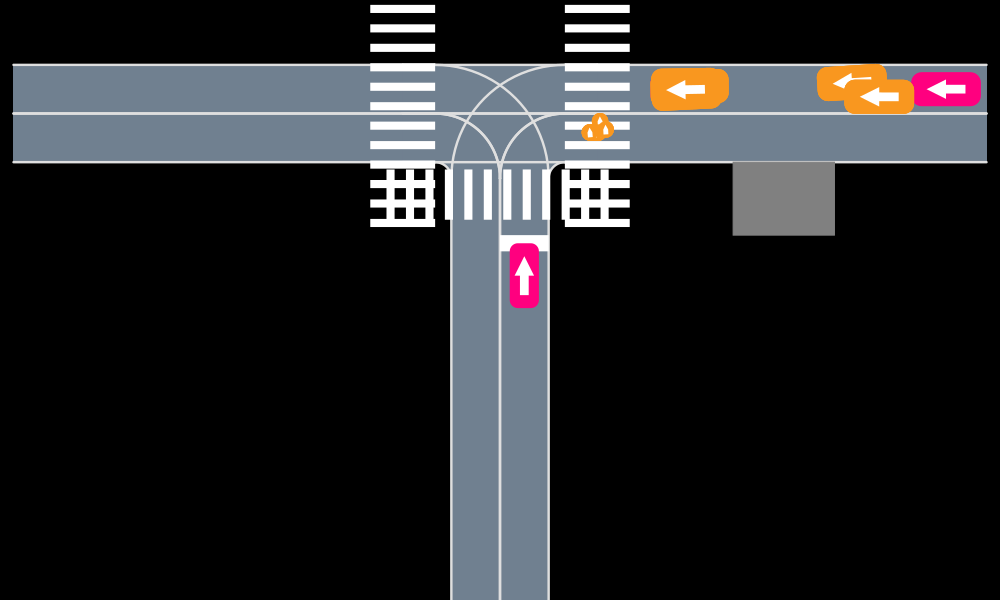

In [183]:
AutoViz.render(hist.state_hist[end], pomdp.env, [PedCarBeliefOverlay(pedcar_pomdp, b, MONOKAI["color4"]) for b in pedcar_beliefs], cam=FitToContentCamera(0.))

## Decomposed policy

In [ ]:
function POMDPs.action(policy::DecMaskedPolicy, b::MultipleAgentsBelief)
    global pomdp
    pedcar_beliefs = create_pedcar_beliefs(pomdp, b) #XXX is using global variable pomdp
    return action(policy, pedcar_beliefs)
end

function POMDPs.value(policy::DecMaskedPolicy, b::MultipleAgentsBelief)
    global pomdp
    pedcar_beliefs = create_pedcar_beliefs(pomdp, b) #XXX is using global variable pomdp
    return value(policy, pedcar_beliefs)
end

function POMDPModelTools.action_info(policy::DecMaskedPolicy, b::MultipleAgentsBelief)
    global pomdp
    pedcar_beliefs = create_pedcar_beliefs(pomdp, b) #XXX is using global variable pomdp
    return action_info(policy, pedcar_beliefs)
end


## Visualize training set

In [14]:
# include("data_generation.jl")

In [4]:
policy = RandomHoldPolicy(pomdp, 5, 0, UrbanAction(0.), rng);

In [36]:
Xc, Yc, Xp, Yp = collect_split_set(pomdp, policy, 400, rng, 1);

In [37]:
Xc

1-element Array{Array{Array{Float64,1},1},1}:
 [[0.0625, -0.416667, 1.0, 0.0, -1.22917, -0.795833, 0.0, 0.0, 1.04167, 0.1875, 0.666667, 0.197917], [0.0625, -0.416667, 1.0, 0.0, -1.22917, -0.795833, 0.0, 0.0, 1.04167, 0.1875, 0.666667, 0.197917], [0.0625, -0.416667, 1.0, 0.0, -1.22917, -0.795833, 0.0, 0.0, 1.04167, 0.1875, 0.666667, 0.197917], [0.0625, -0.416667, 1.0, 0.0, -1.22917, -0.795833, 0.0, 0.0, 1.04167, 0.1875, 0.666667, 0.197917], [0.0625, -0.416667, 1.0, 0.0, -1.22917, -0.795833, 0.0, 0.0, 1.04167, 0.1875, 0.666667, 0.197917], [0.0625, -0.416667, 1.0, 0.0, -1.22917, -0.795833, 0.0, 0.0, 1.04167, 0.1875, 0.666667, 0.197917], [0.0625, -0.416667, 1.0, 0.0, -1.22917, -0.795833, 0.0, 0.0, 1.04167, 0.1875, 0.666667, 0.197917], [0.0625, -0.416667, 1.0, 0.0, -1.22917, -0.795833, 0.0, 0.0, 1.04167, 0.1875, 0.666667, 0.197917], [0.0625, -0.416667, 1.0, 0.0, -1.22917, -0.795833, 0.0, 0.0, 1.04167, 0.1875, 0.666667, 0.197917], [0.0625, -0.416667, 1.0, 0.0, -1.22917, -0.795833, 0.0, 0.0, 

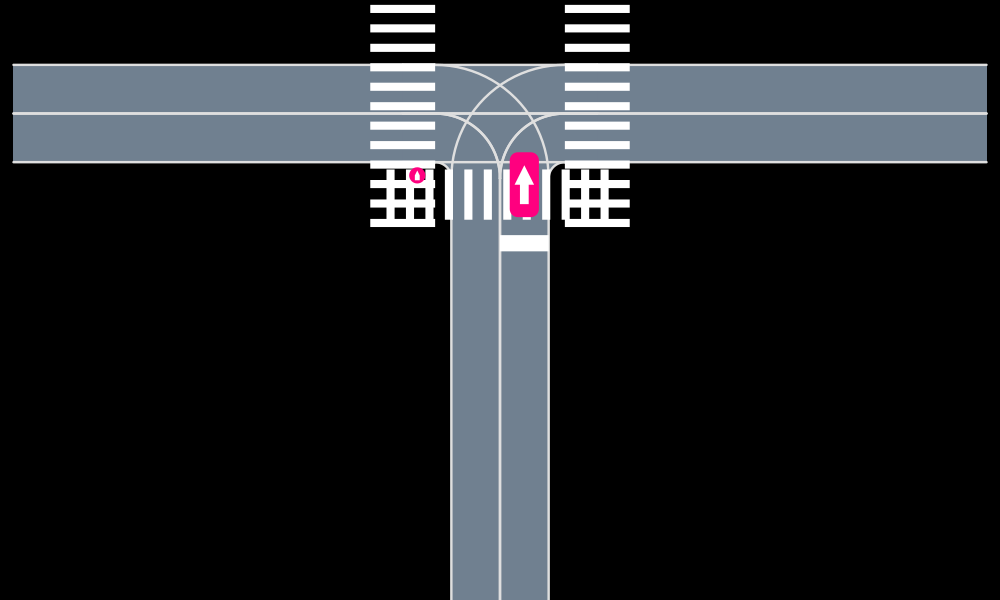

In [31]:
s = obs_to_scene(ped_pomdp, Xp[1][200])
AutoViz.render(s, pomdp.env, cam=FitToContentCamera(0.0))

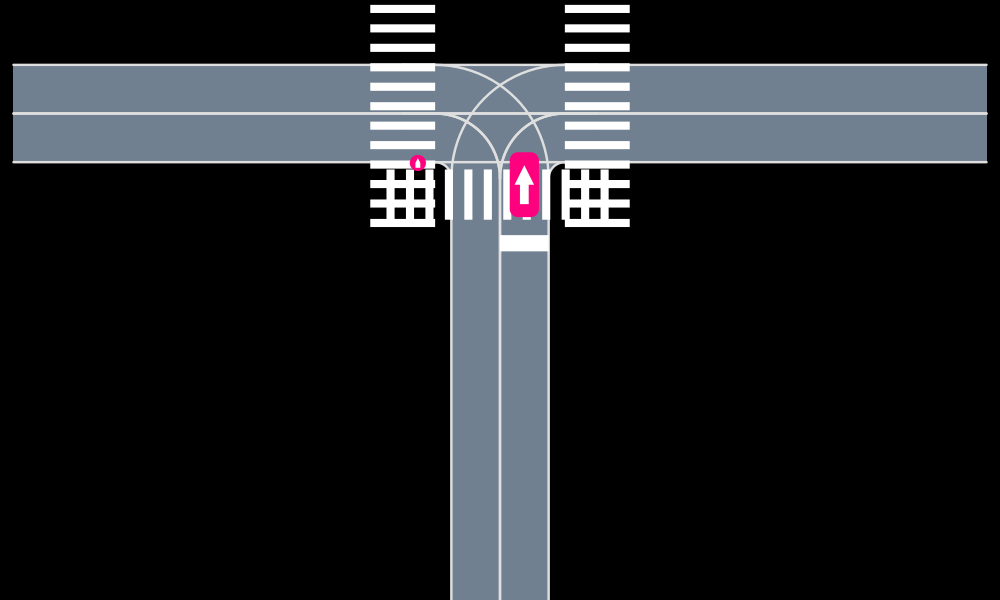

In [35]:
b = process_single_entity_prediction(ped_pomdp, Yp[1][200], Xp[1][200])
s = obs_to_scene(ped_pomdp, b)
AutoViz.render(s, pomdp.env, cam=FitToContentCamera(0.))

In [16]:
X, Y = collect_set(pomdp, policy , 400, rng, 1);

In [17]:
trajind = 1
trajx = X[trajind]
trajy = Y[trajind]
tb = process_prediction.(pomdp, trajy, trajx)
scenes = obs_to_scene.(pomdp, tb);
sind = 250
obs = [veh for veh in obs_to_scene(pomdp, trajx[sind]) if veh.id != EGO_ID]
render(scenes[sind], pomdp.env, [GaussianSensorOverlay(sensor=pomdp.sensor, o=obs, color=MONOKAI["color2"]), OcclusionOverlay(obstacles=pomdp.env.obstacles)], 
                cam=cam, car_colors=get_colors(scenes[1]))

MethodError: MethodError: no method matching length(::UrbanPOMDP)
Closest candidates are:
  length(!Matched::Type{LaneFollowingAccel}) at /mnt/c/Users/Maxime/wsl/.julia/dev/AutomotiveDrivingModels/src/1d/actions.jl:9
  length(!Matched::Type{AccelTurnrate}) at /mnt/c/Users/Maxime/wsl/.julia/dev/AutomotiveDrivingModels/src/2d/actions/accel_turnrate.jl:6
  length(!Matched::Type{AccelDesang}) at /mnt/c/Users/Maxime/wsl/.julia/dev/AutomotiveDrivingModels/src/2d/actions/accel_desang.jl:6
  ...

In [18]:
duration, fps, render_hist = animate_scenes(scenes, pomdp.env, sim_dt=pomdp.ΔT)
speed_factor = 1
film = roll(render_hist, fps = speed_factor*fps, duration = duration/speed_factor)

UndefVarError: UndefVarError: scenes not defined

In [19]:
tx, ty = generate_trajectory(pomdp, policy, 100, rng);
tx = convert.(Vector{Float64}, tx)
duration, fps, render_hist = animate_scenes(obs_to_scene.(pomdp, tx), pomdp.env, sim_dt=pomdp.ΔT)
speed_factor = 1
film = roll(render_hist, fps = speed_factor*fps, duration = duration/speed_factor)

MethodError: MethodError: no method matching length(::UrbanPOMDP)
Closest candidates are:
  length(!Matched::Type{LaneFollowingAccel}) at /mnt/c/Users/Maxime/wsl/.julia/dev/AutomotiveDrivingModels/src/1d/actions.jl:9
  length(!Matched::Type{AccelTurnrate}) at /mnt/c/Users/Maxime/wsl/.julia/dev/AutomotiveDrivingModels/src/2d/actions/accel_turnrate.jl:6
  length(!Matched::Type{AccelDesang}) at /mnt/c/Users/Maxime/wsl/.julia/dev/AutomotiveDrivingModels/src/2d/actions/accel_desang.jl:6
  ...

In [20]:
function build_presence_mask(y::Vector{Float64}, car_pres_ind=5, ped_pres_ind=10)
    n_features = 5
    mask = ones(length(y))
    if y[car_pres_ind] == 0.
        mask[1:car_pres_ind-1] .= 0. 
    end
    if y[ped_pres_ind] == 0.
        mask[ped_pres_ind-n_features+1:ped_pres_ind-1] .= 0.
    end
    return mask
end

build_presence_mask (generic function with 3 methods)

In [21]:
model = models[1]
function loss(x, y)
    mask = build_presence_mask.(y) # same size as y
    l = mean(mse.(model.(x), y, mask)) # mean over the trajectory
    Flux.truncate!(model)
    Flux.reset!(model)
    return l
end

function mse(ypred, y, mask)
    return sum(mask.*(ypred - y).^2)/length(y)
end

mse (generic function with 1 method)

In [22]:
norm([model(x)[5] for x in tx])

UndefVarError: UndefVarError: norm not defined

In [23]:
mask = build_presence_mask.(ty)

101-element Array{Array{Float64,1},1}:
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
 [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 ⋮                                                 
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 [1.0, 1.0, 1.0, 1.0, 1.0

In [24]:
tb = process_prediction.(pomdp, ty, tx)
duration, fps, render_hist = animate_scenes(obs_to_scene.(pomdp, tb), pomdp.env, sim_dt=pomdp.ΔT)
speed_factor = 1
film = roll(render_hist, fps = speed_factor*fps, duration = duration/speed_factor)

MethodError: MethodError: no method matching length(::UrbanPOMDP)
Closest candidates are:
  length(!Matched::Type{LaneFollowingAccel}) at /mnt/c/Users/Maxime/wsl/.julia/dev/AutomotiveDrivingModels/src/1d/actions.jl:9
  length(!Matched::Type{AccelTurnrate}) at /mnt/c/Users/Maxime/wsl/.julia/dev/AutomotiveDrivingModels/src/2d/actions/accel_turnrate.jl:6
  length(!Matched::Type{AccelDesang}) at /mnt/c/Users/Maxime/wsl/.julia/dev/AutomotiveDrivingModels/src/2d/actions/accel_desang.jl:6
  ...

In [25]:
function process_prediction(pomdp::UrbanPOMDP, b::Vector{Float64}, o::Vector{Float64})
    n_features = 4
    n_obstacles = pomdp.max_obstacles
    b_ = zeros(length(o)) # should be 12 + obstacles
    b_[1:4] = o[1:4] # ego state fully observable
    # get car state from b
    car_presence = b[5]
    if 1/(1 + exp(-car_presence)) > 0.5 # softmax 
        b_[n_features+1:2*n_features] = b[1:4]
    else
        # absent
        b_[n_features+1:2*n_features] = normalized_off_the_grid_pos(pomdp, o[1], o[2])
    end
    
    # get ped state from b 
    ped_presence = b[10]
    if 1/(1 + exp(-ped_presence)) > 0.5 # softmax 
        b_[2*n_features+1:3*n_features] = b[6:9]
    else
        # absent 
        b_[2*n_features+1:3*n_features] = normalized_off_the_grid_pos(pomdp, o[1], o[2])
    end
            
    b_[end - n_features*n_obstacles + 1:end] = o[end - n_features*n_obstacles + 1:end]
    return b_
end

function normalized_off_the_grid_pos(pomdp::UrbanPOMDP,normalized_ego_x::Float64, normalized_ego_y::Float64)
    pos_off = get_off_the_grid(pomdp)
    max_ego_dist = get_end(pomdp.env.roadway[pomdp.ego_goal])
    return [pos_off.posG.x/max_ego_dist - normalized_ego_x, pos_off.posG.y/max_ego_dist - normalized_ego_y, pos_off.posG.θ, 0.]
end

ErrorException: error in method definition: function RNNFiltering.process_prediction must be explicitly imported to be extended

In [26]:
tb = process_prediction.(pomdp, ty, tx)
duration, fps, render_hist = animate_scenes(obs_to_scene.(pomdp, tb), pomdp.env, sim_dt=pomdp.ΔT)
speed_factor = 1
film = roll(render_hist, fps = speed_factor*fps, duration = duration/speed_factor)

MethodError: MethodError: no method matching length(::UrbanPOMDP)
Closest candidates are:
  length(!Matched::Type{LaneFollowingAccel}) at /mnt/c/Users/Maxime/wsl/.julia/dev/AutomotiveDrivingModels/src/1d/actions.jl:9
  length(!Matched::Type{AccelTurnrate}) at /mnt/c/Users/Maxime/wsl/.julia/dev/AutomotiveDrivingModels/src/2d/actions/accel_turnrate.jl:6
  length(!Matched::Type{AccelDesang}) at /mnt/c/Users/Maxime/wsl/.julia/dev/AutomotiveDrivingModels/src/2d/actions/accel_desang.jl:6
  ...